In [17]:
#!pip install deepxde

The one-dimensional diffusion partial differential equation (PDE) being solved in this project is given by:

\begin{equation}
     \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + g(x,t)
\end{equation}

Here, \(g(x, t)\) is a source term defined as:

\begin{equation}
      g(x,t) = - e^{-t} \left( \sin(\pi x) - \pi^2 \sin(\pi x) \right)
\end{equation}

This equation is being solved over the domain:

\begin{equation}
\left\{\begin{array}{l}
x \in[-1 ; 1] \\
t \in[0 ; 1]
\end{array}\right.
\end{equation}

The initial condition for the PDE is:

\begin{equation}
      u(x,0) = \sin(\pi x)
\end{equation}

And the boundary conditions, specified as Dirichlet conditions, are:

\begin{equation}
\left\{\begin{array}{l}
u(-1, t) = 0 \\
u(1, t) = 0
\end{array}\right.
\end{equation}

This problem is being solved using a neural network trained with the DeepXDE library. The architecture of the neural network consists of an input layer with two neurons, three hidden layers each with 32 neurons, and an output layer with one neuron. The activation function for the neurons is the hyperbolic tangent (tanh), and the initializer for the weights and biases is the Glorot uniform initializer. The Adam optimizer is used for training the network, and the learning rate is set to 0.0001. The model is trained for 50000 iterations, and the L2 relative error is used as the metric to track the performance of the model. The solution of the model is compared with the analytical solution of the PDE to evaluate its accuracy.

In [18]:
# Import necessary modules
import deepxde as dde
import numpy as np
import math
from deepxde.backend import tf
import matplotlib.pyplot as plt

In [19]:
# Set the minimum and maximum values for x and t
xmin, tmin = -1, 0
xmax, tmax = 1, 1

# Create a geometry object representing the x interval and a time domain object for the t interval
geom = dde.geometry.Interval(xmin, xmax)
timedomain = dde.geometry.TimeDomain(tmin, tmax)

# Create a GeometryXTime object representing the 2D domain of the problem
geotime = dde.geometry.GeometryXTime(geom, timedomain)

In [20]:
# Define the partial differential equation to be solved
def pde(x, u):
    """
    Args:
        x: Tensor. Input tensor of size [batch_size, num_dims], where num_dims is number of dimensions.
        u: Tensor. Output tensor of size [batch_size, num_outputs], where num_outputs is number of outputs.

    Returns:
        Residual of the PDE.
    """
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)

    return (du_t - du_xx + tf.exp(-x[:, 1:]) * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1])))


In [21]:
# Define the analytical solution to the PDE
def func(x):
    """
    Args:
        x: Tensor. The coordinates at which to evaluate the solution.

    Returns:
        Tensor. The solution evaluated at the points defined by `x`.
    """
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

# Set boundary conditions
BC = dde.DirichletBC(geotime, func, lambda _, on_boundary:on_boundary) # Boundary condition
IC = dde.IC(geotime, func, lambda _, on_initial:on_initial) # Initial condition

In [22]:
# Define training data
data = dde.data.TimePDE(geotime, pde, [BC, IC], num_domain = 800, num_boundary = 200, num_initial = 200, num_test = 10000, solution=func)

In [23]:
# Define neural network architecture
layer_size = [2] + [32]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"

# Initialize feed-forward neural network (FNN)
net = dde.nn.FNN(layer_size, activation, initializer)

# Initialize model using data and FNN
model = dde.Model(data, net)

#model.compile("adam", lr=1e-3)
#model.train(iterations=2000)
#model.compile("L-BFGS")

# Compile model using the Adam optimizer and a learning rate of 0.0001, tracking the L2 relative error metric
model.compile("adam", lr=0.0001, metrics = ["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.100926 s

'compile' took 0.668257 s



In [24]:
# Train model for 50000 iterations and keep track of loss history
loss_history, train_state = model.train(iterations=50000)

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.79e+01, 4.99e-02, 4.97e-01]    [1.68e+01, 4.99e-02, 4.97e-01]    [1.10e+00]    
1000      [1.42e+00, 5.40e-02, 3.29e-02]    [7.46e-01, 5.40e-02, 3.29e-02]    [3.11e-01]    
2000      [5.14e-02, 2.84e-02, 7.27e-03]    [4.10e-02, 2.84e-02, 7.27e-03]    [1.94e-01]    
3000      [1.77e-02, 1.19e-02, 1.90e-03]    [1.35e-02, 1.19e-02, 1.90e-03]    [1.26e-01]    
4000      [6.27e-03, 3.98e-03, 8.83e-04]    [5.16e-03, 3.98e-03, 8.83e-04]    [7.25e-02]    
5000      [3.38e-03, 1.71e-03, 6.93e-04]    [2.87e-03, 1.71e-03, 6.93e-04]    [4.71e-02]    
6000      [2.03e-03, 7.81e-04, 3.87e-04]    [1.78e-03, 7.81e-04, 3.87e-04]    [3.18e-02]    
7000      [1.06e-03, 2.76e-04, 1.83e-04]    [1.00e-03, 2.76e-04, 1.83e-04]    [1.93e-02]    
8000      [5.28e-04, 5.53e-05, 6.21e-05]    [5.41e-04, 5.53e-05, 6.21e-05]    [8.85e-03]    
9000      [2.47e-04, 1.43e-05, 2.63e-05]    [2.62e-

In [25]:
x_data = np.linspace(xmin, xmax, num=1000)
t_data = np.linspace(tmin, tmax, num = 1000)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator=pde)

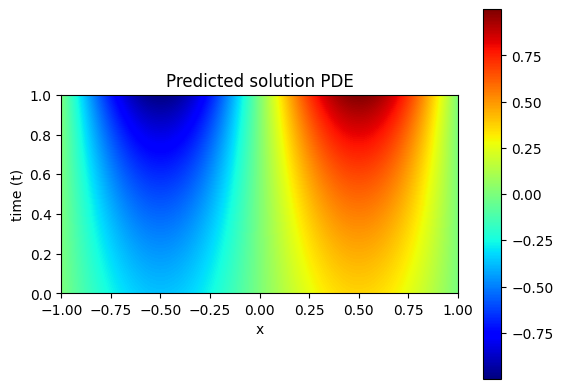

In [26]:
# Generate plots for predicted solution, analytical solution and absolute error
extend = xmin, xmax, tmin, tmax
plt.imshow(predicted_solution.reshape((1000, 1000)), cmap="jet", extent = extend)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("time (t)")
plt.title("Predicted solution PDE")
plt.savefig("Predicted_1.png")

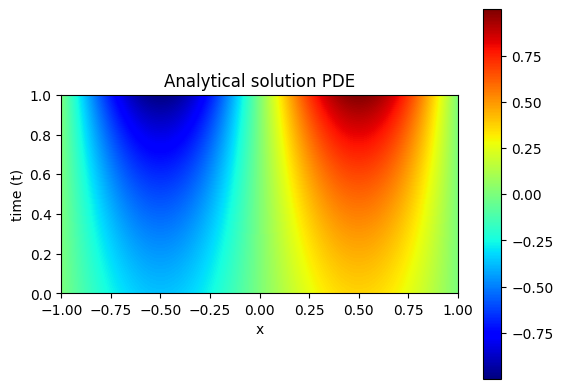

In [27]:
plt.imshow(func(test_domain).reshape((1000, 1000)), cmap="jet", extent = extend)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("time (t)")
plt.title("Analytical solution PDE")
plt.savefig("solution.png")

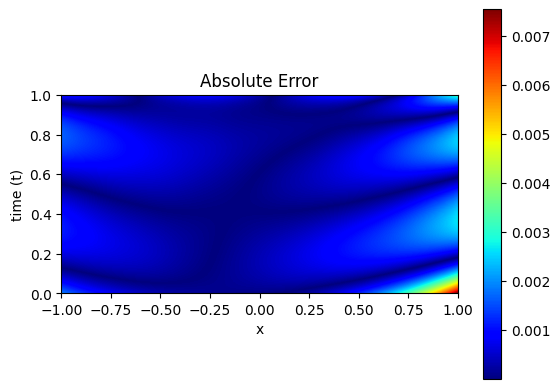

In [28]:
plt.imshow((abs(predicted_solution-func(test_domain))).reshape((1000, 1000)), cmap="jet", extent = extend)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("time (t)")
plt.title("Absolute Error")
#plt.show()
plt.savefig("Residuals_1.png")

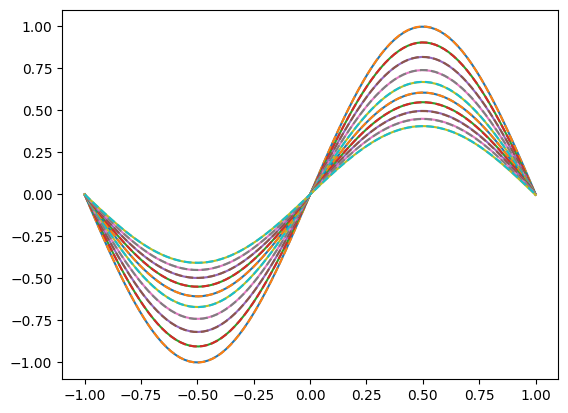

In [29]:
# Plot model predictions and true values over time
t_long = np.arange(tmin, tmax, 0.1)
x_long = np.linspace(xmin, xmax, num=100)
for i in range(len(t_long)):
    t_x, t_t = np.meshgrid(x_long, t_long[i])
    t_domain = np.vstack((np.ravel(t_x), np.ravel(t_t))).T
    y_x=model.predict(t_domain)
    y_true_x = func(t_domain)
    plt.plot(x_long, y_x)
    plt.plot(x_long, y_true_x,"--")

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


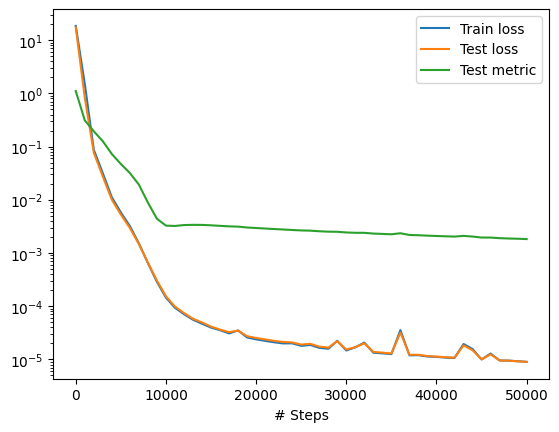

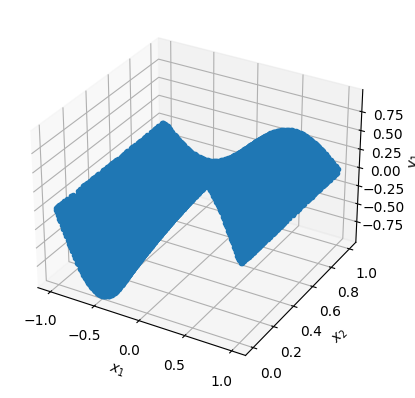

In [30]:
# Save the loss history and training state
dde.saveplot(loss_history, train_state, issave=True, isplot=True)